## Korrelationen untersuchen ##

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from IPython.display import HTML

In [3]:
%store -r columns
%store -r columns_encoded
%store -r data
%store -r data_encoded

columns = columns
columns_encoded = columns_encoded
data = data
data_encoded = data_encoded

# Korrelationsanalyse auf den vorverarbeiteten Daten *ohne* Encoding #

<Axes: >

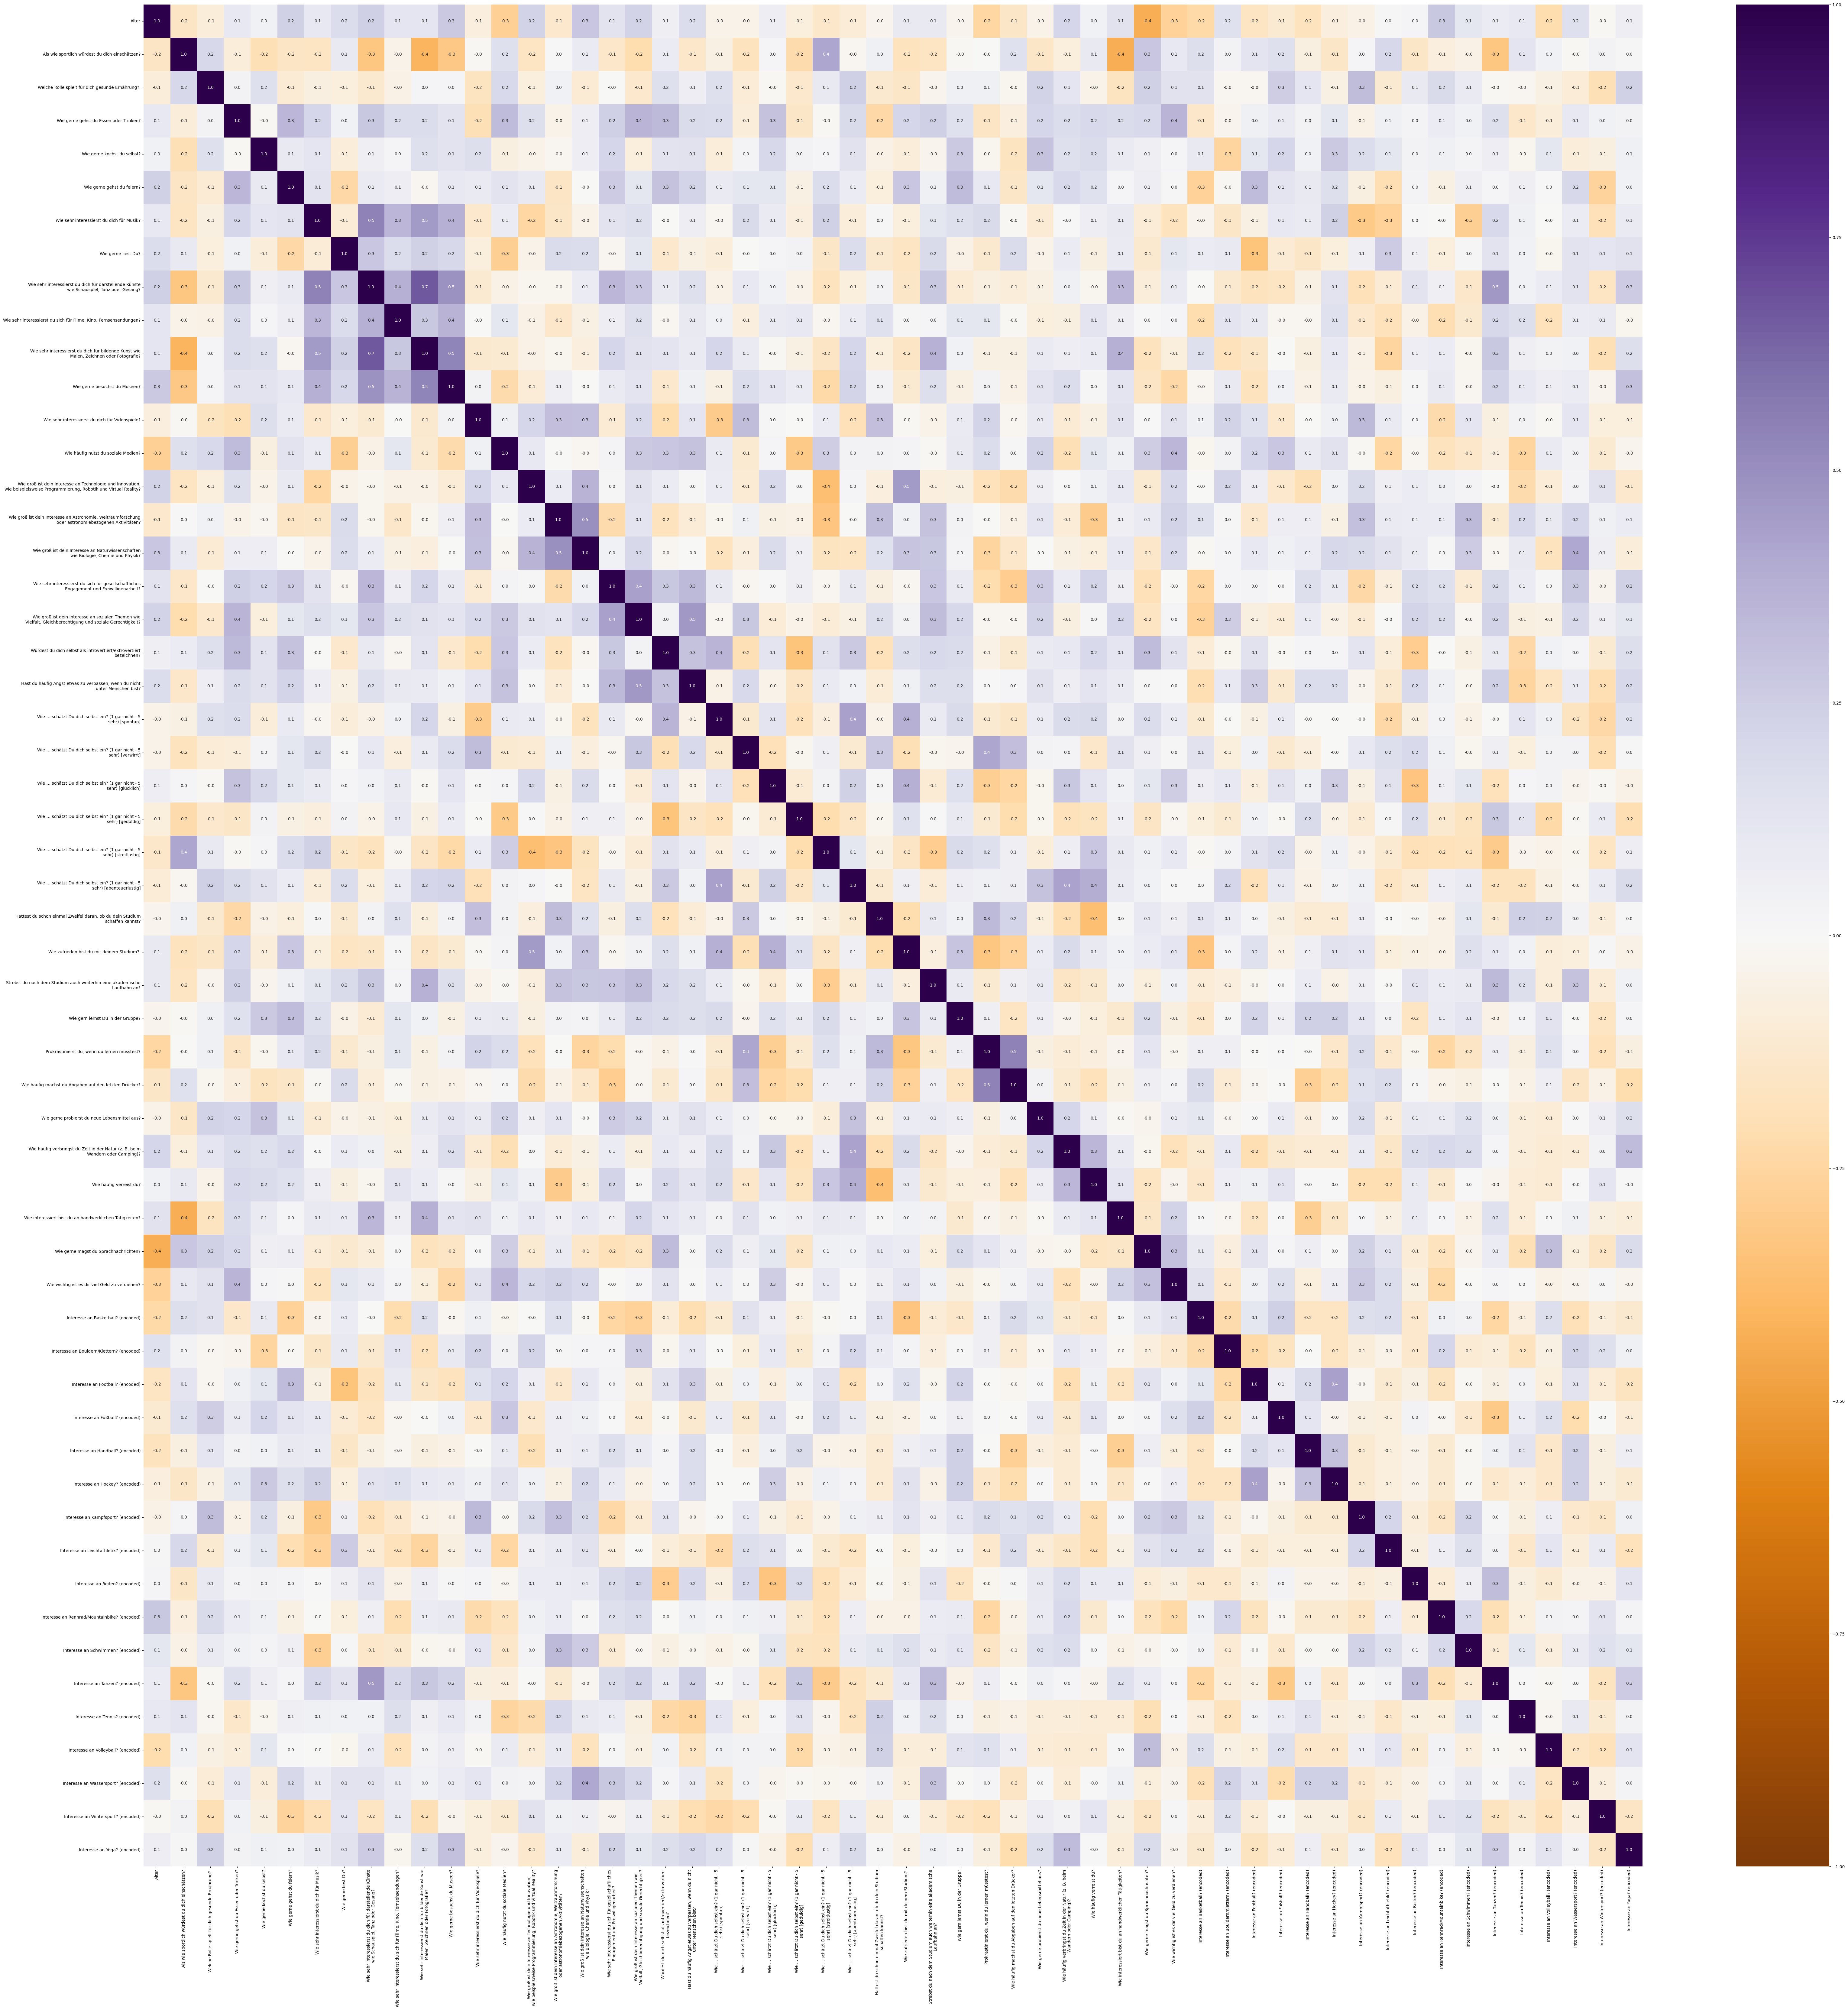

In [4]:
fig, ax = plt.subplots(figsize=(80, 80))

sb.heatmap(data.corr(numeric_only=True),
           annot=True, cmap="PuOr",fmt=".1f",
           vmin=-1, vmax=1)

# TODO: Interessante Ausschnitte der Matrix raussuchen und seperat darstellen #

## Höchste und niedrigste Korrelationen raussuchen, um das ganze übersichtlicher zu machen:

In [5]:
correlations = data.corr(numeric_only=True)

# transform the correlation matrix into a dataframe with three columns
# this will create a row for each pair of columns with the correlation value as the third column
# also exclude all duplicate correlations (e.g. correlation between column1 and column2 and column2 and column1)
# based on https://stackoverflow.com/a/51071640
correlation_df = correlations.unstack().drop_duplicates().reset_index()
correlation_df.columns = ["column1", "column2", "correlation"]

# exclude all correlations with 1 as value (probably with the same column)
# correlation_df = correlation_df.loc[correlation_df["correlation"] < 1 ]

# sort by correlation value
sorted_correlations = correlation_df.sort_values(by="correlation", ascending=False)
sorted_correlations.columns = ["column1", "column2", "correlation"]

# remove all correlations with the same column
sorted_correlations = sorted_correlations[sorted_correlations["column1"] != sorted_correlations["column2"]]

# round the correlation values to one decimal place
sorted_correlations["correlation"] = sorted_correlations["correlation"].apply(lambda x: round(x, 1))

highest_and_lowest_correlations = pd.concat([sorted_correlations.head(15), sorted_correlations.tail(15)])

display(HTML(highest_and_lowest_correlations.to_html()))

## TODO: Hier interessante Korrelationen raussuchen und plotten ##

In [6]:
cross_table_malen_schauspiel = pd.crosstab(index=data[columns.malen], columns=data[columns.schauspiel])

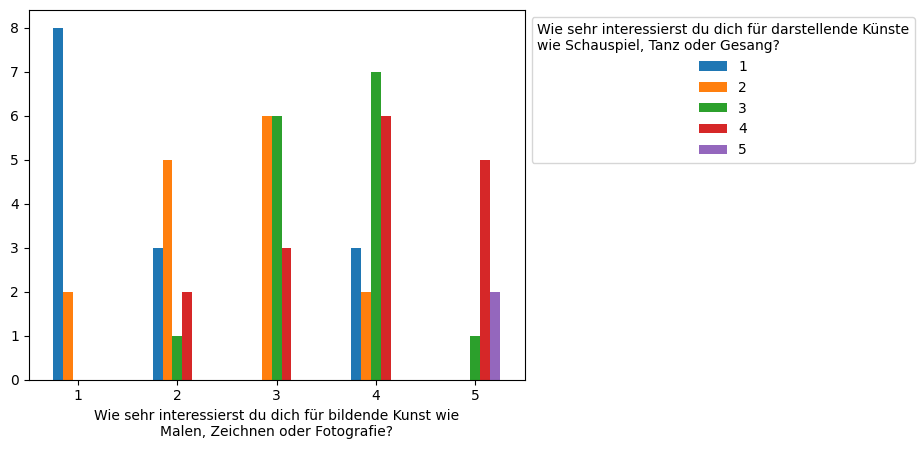

In [7]:
ax = cross_table_malen_schauspiel.plot.bar(rot=0)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Plot correlation graphs for the features related to drawing, acting, music, museums #

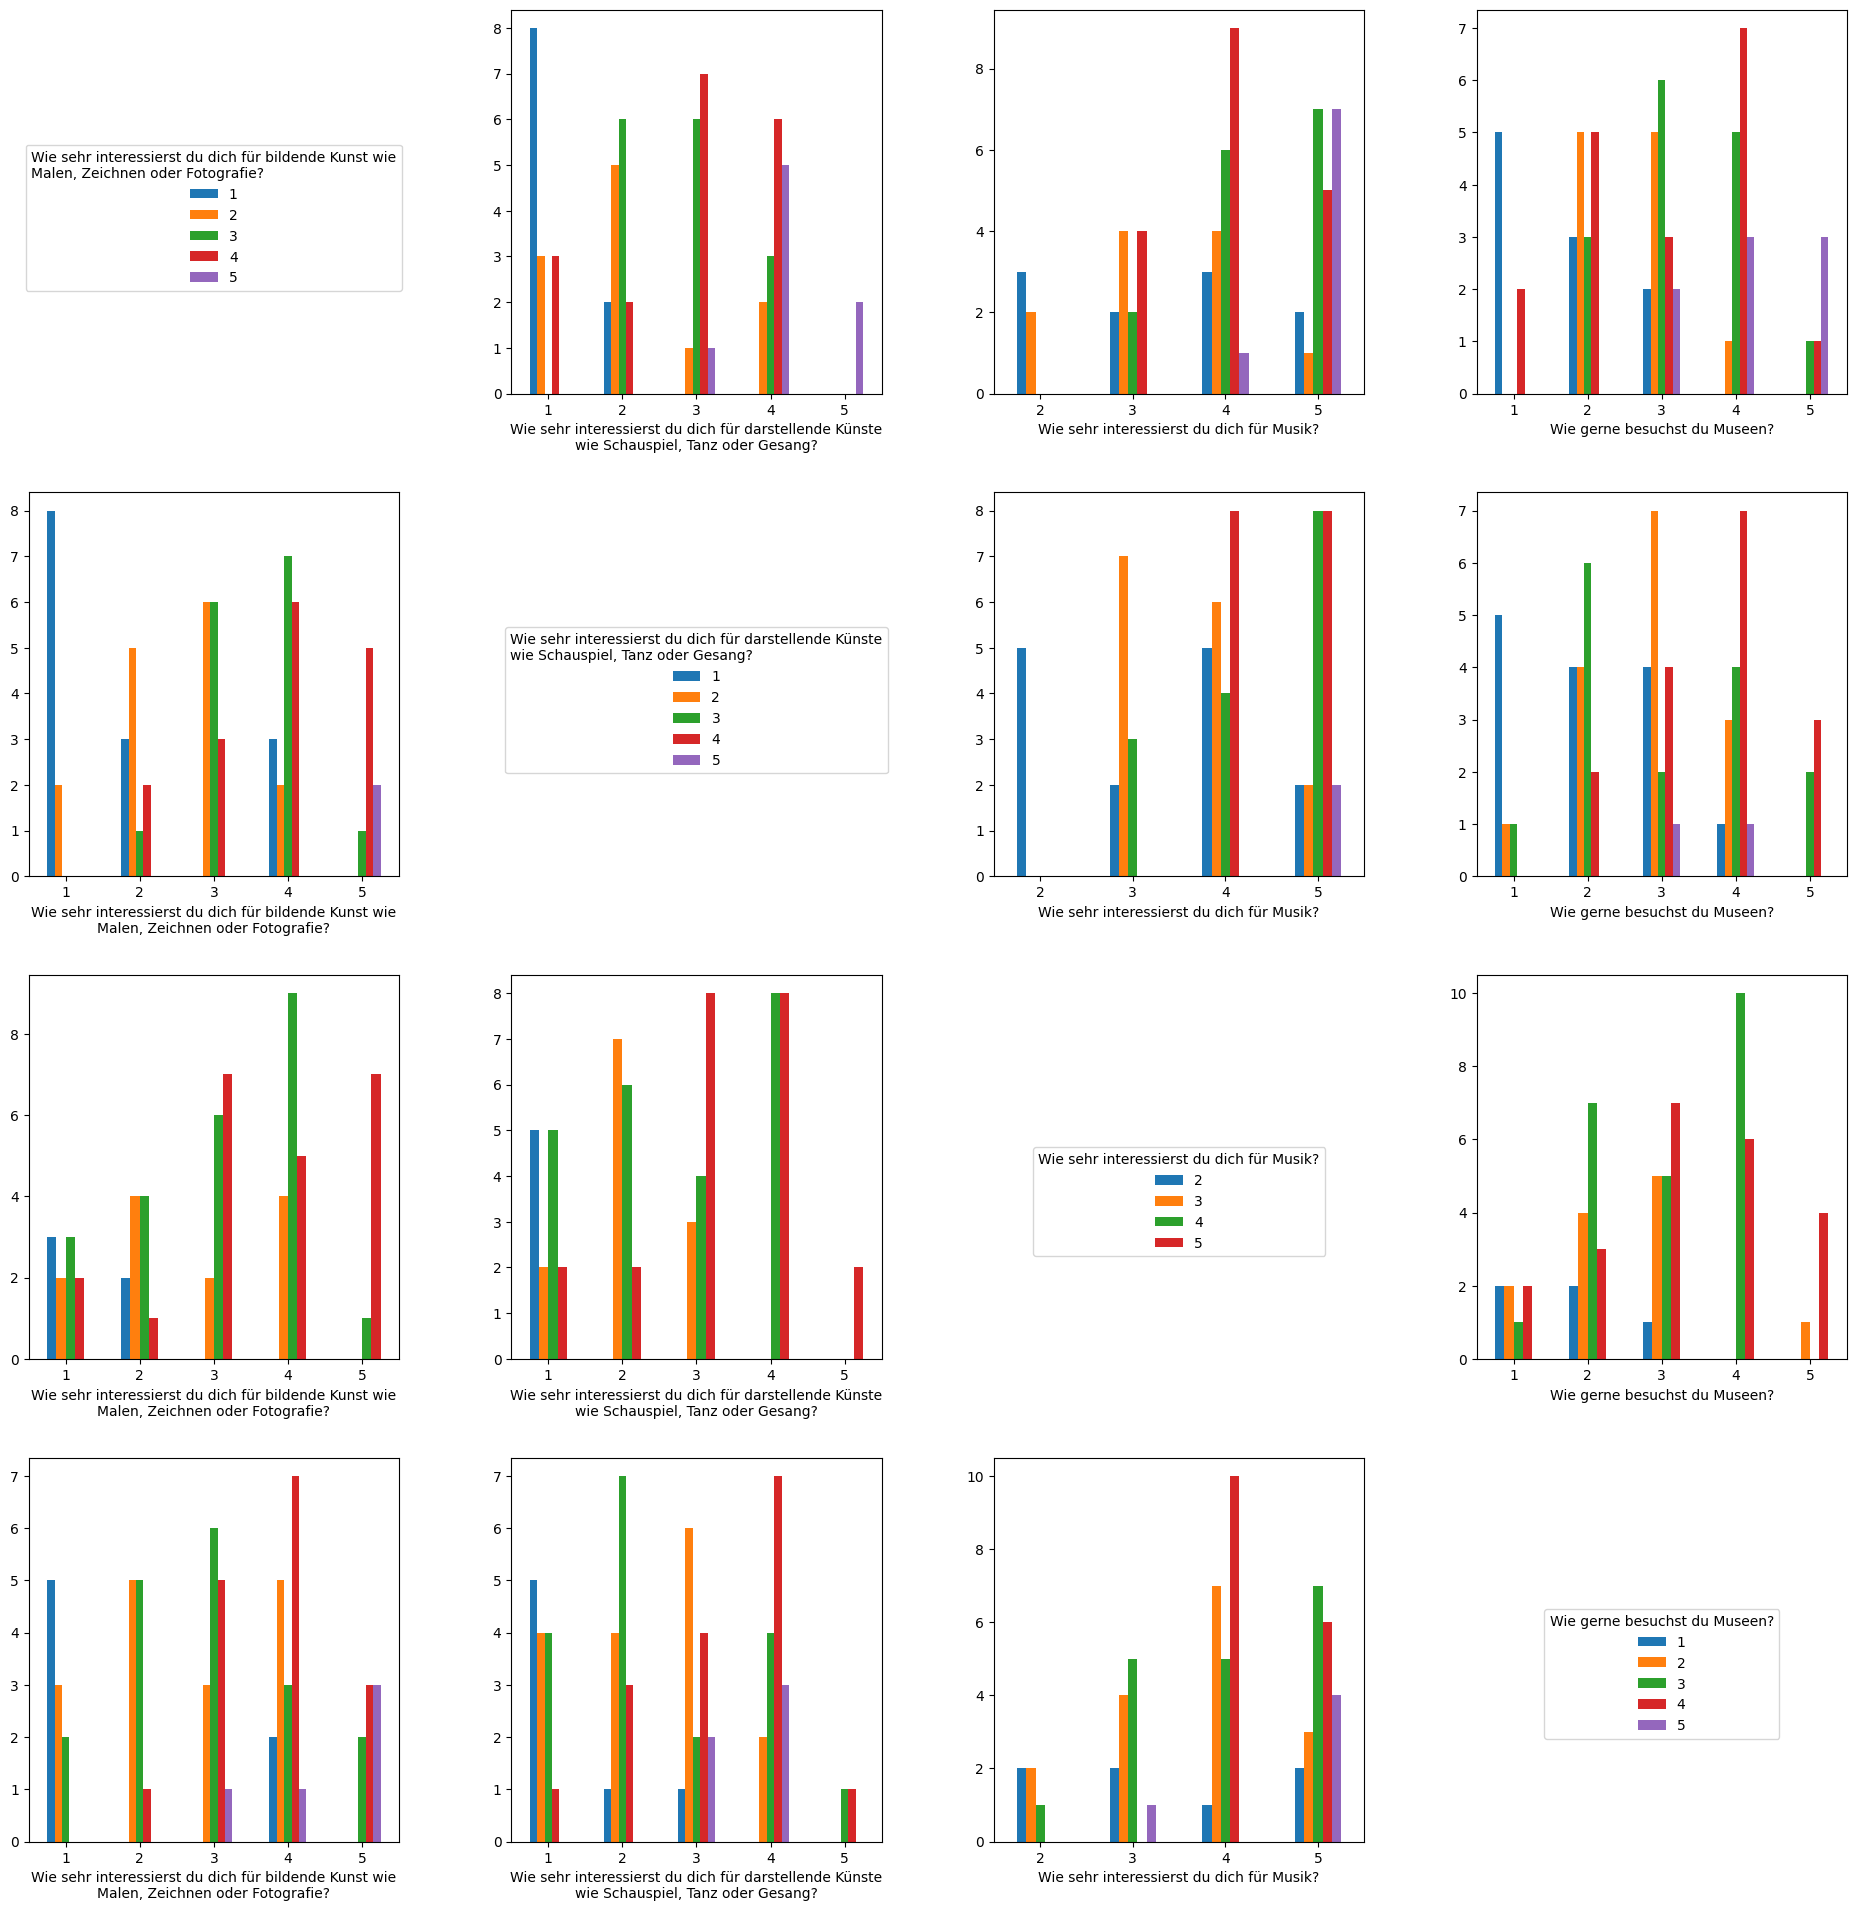

In [60]:
import matplotlib


fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.tight_layout(pad=5)

for idx1, col1 in enumerate([columns.malen, columns.schauspiel, columns.musik, columns.museumsbesuche]):
    for idx2, col2 in enumerate([columns.malen, columns.schauspiel, columns.musik, columns.museumsbesuche]):
        if col1 != col2:
            cross_tab = pd.crosstab(data[col1], data[col2])
            # plot without legend because we only need it once per row
            sub_plt = cross_tab.plot.bar(ax=axes[idx2, idx1], rot=0, ylabel="", legend=False)
        else:
            # plot anyways but then hide anything but the legend
            fake_cross_tab = pd.crosstab(data[col1], data[col2])
            fake_plot = fake_cross_tab.plot.bar(ax=axes[idx2, idx1], rot=0, ylabel="")
            axes[idx1,idx2].set_axis_off()
            for child in fake_plot.get_children():
                if not isinstance(child, matplotlib.legend.Legend):
                    child.set_visible(False)
            sb.move_legend(fake_plot, "lower center", bbox_to_anchor=(0.5, 0.25))

# TODO: Keep this or change like above? #

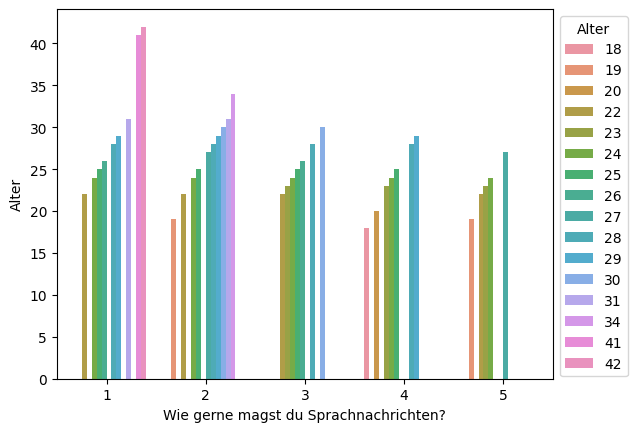

In [9]:
ax = sb.barplot(data[[columns.alter, columns.sprachnachrichten]], x=columns.sprachnachrichten, y=columns.alter, hue=columns.alter)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

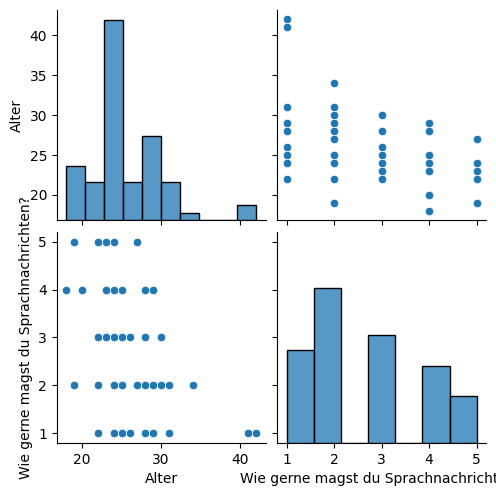

In [10]:
sb.pairplot(data[[columns.alter, columns.sprachnachrichten]], diag_kind="hist")

# Korrelationsanalyse auf den vorverarbeiteten Daten *mit* Encoding #

--> Die Matrix ist kaum ablesbar, zeigt aber schon, dass in den encodeten Features teilweise sehr hohe Korrelationen auftreten \
--> Mehr dazu unten

<Axes: >

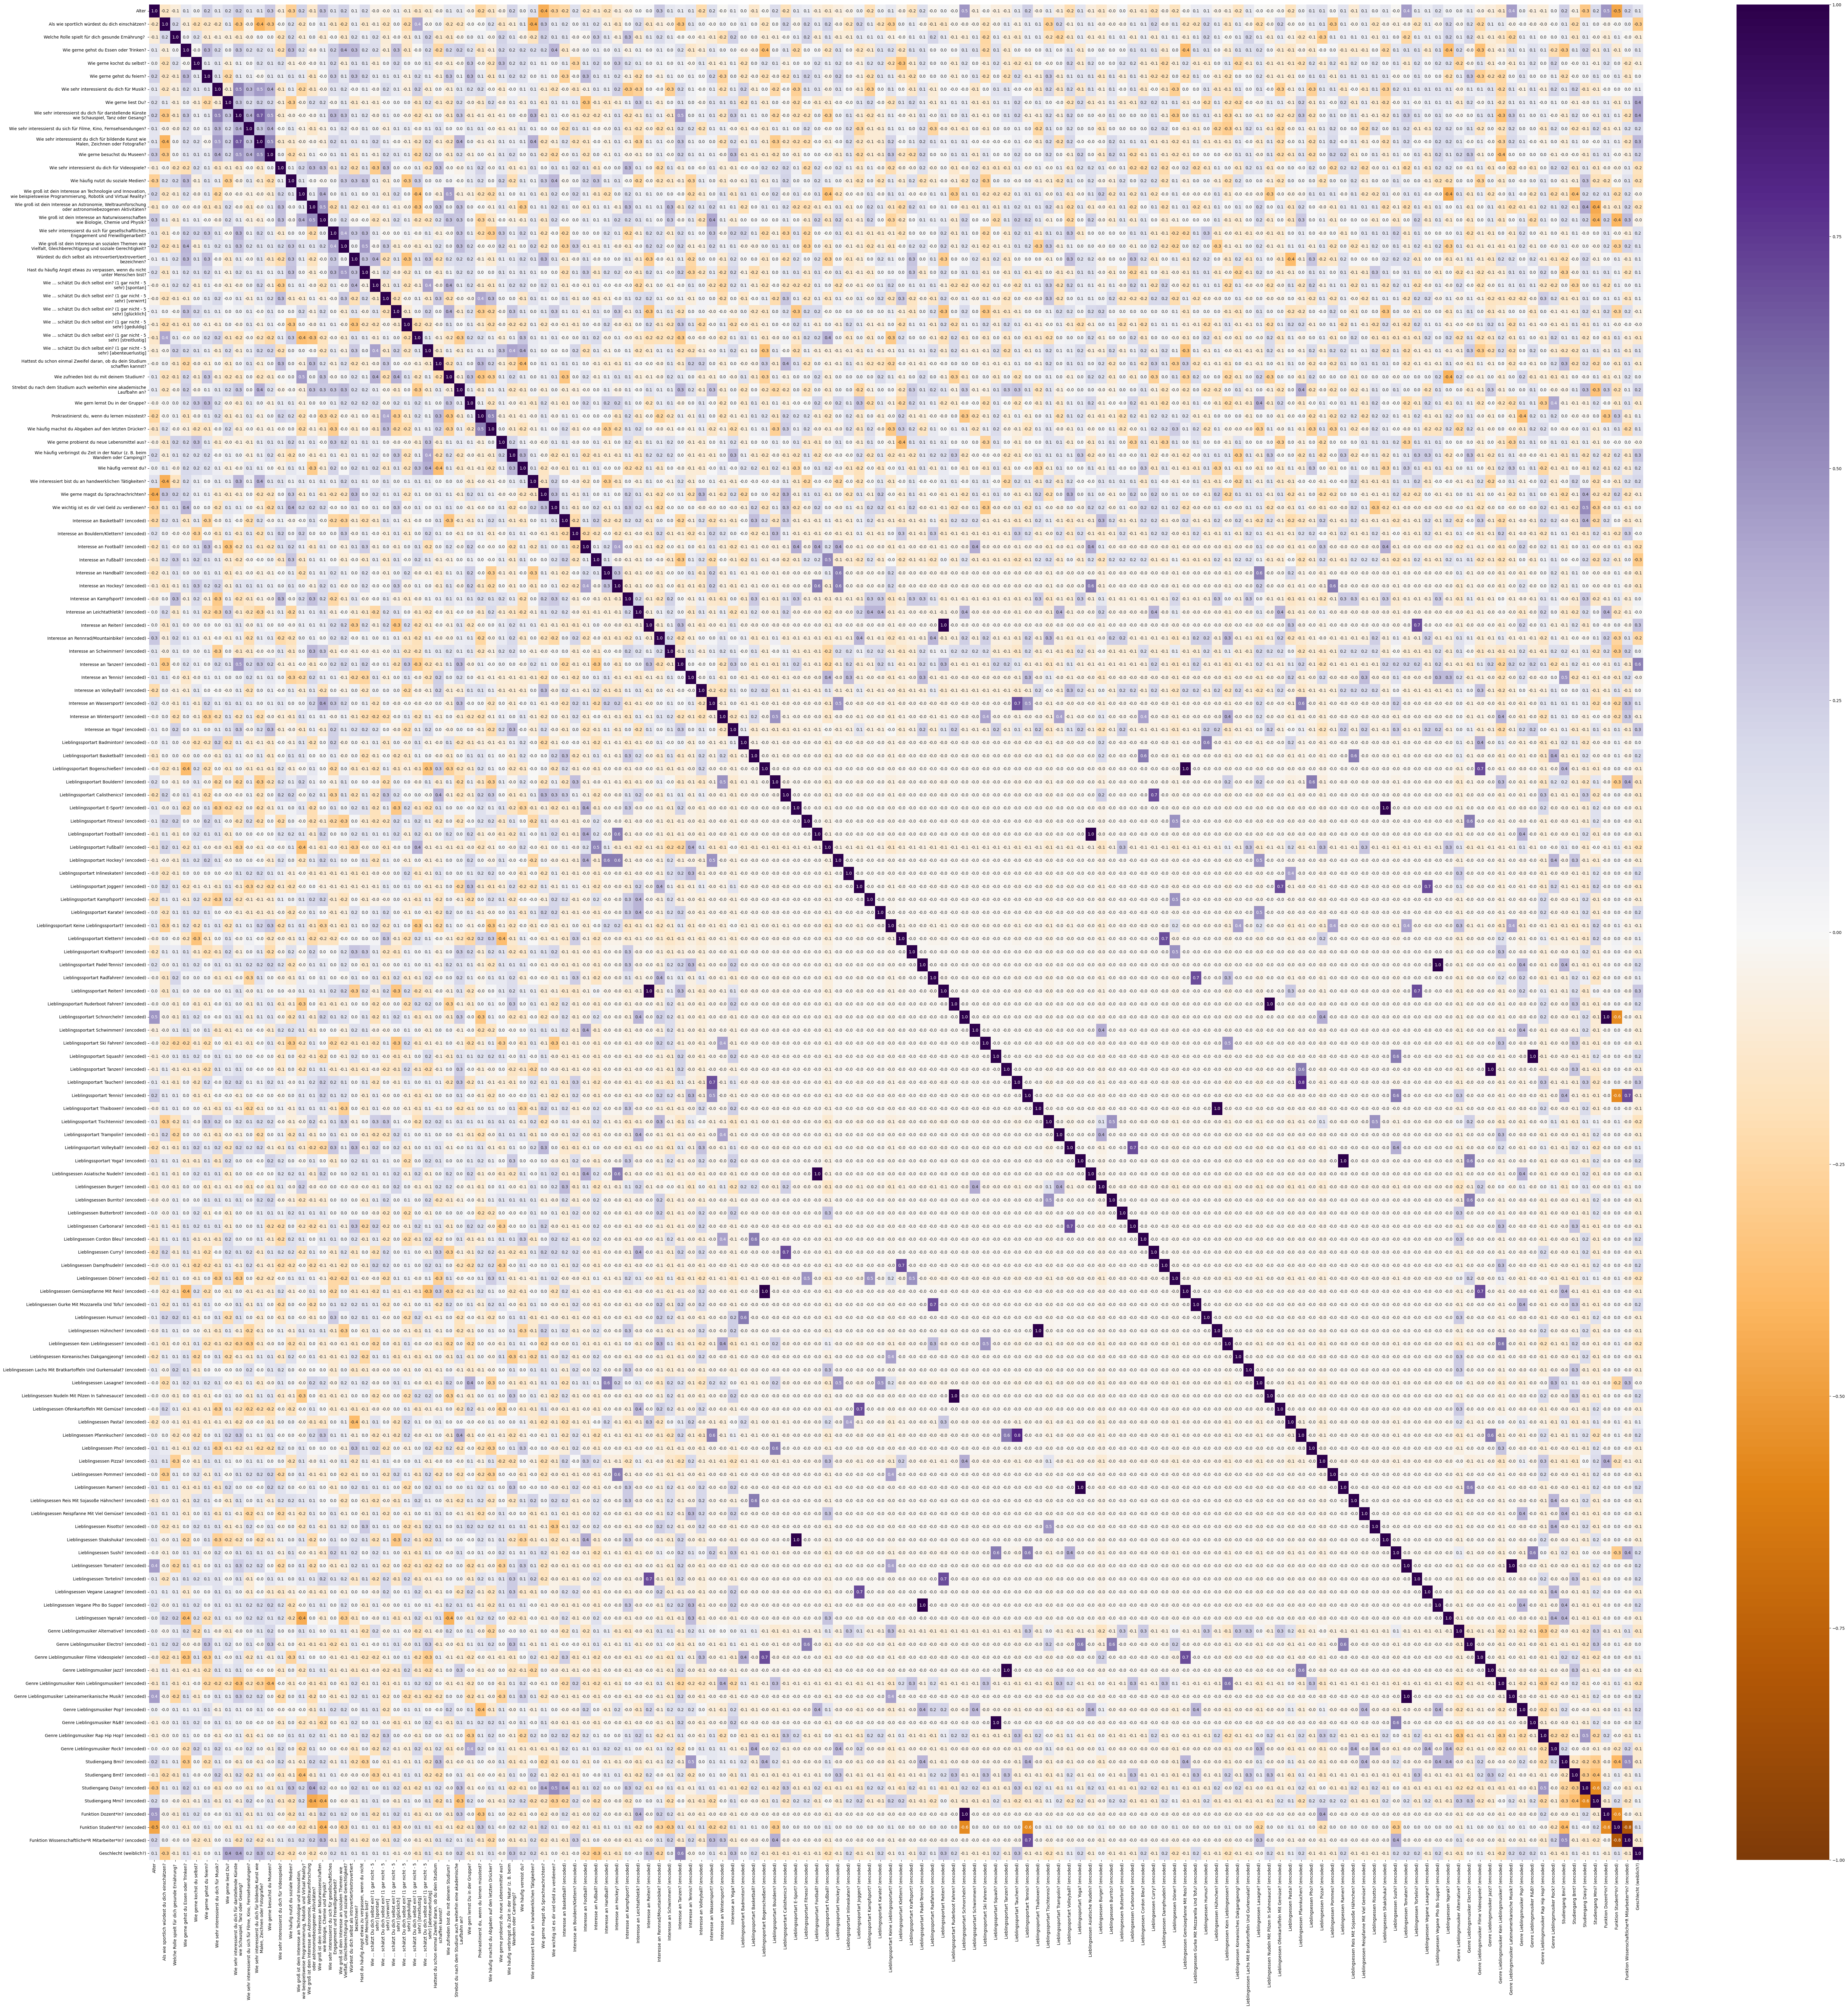

In [11]:
fig, ax = plt.subplots(figsize=(80, 80))

sb.heatmap(data_encoded.corr(numeric_only=True),
           annot=True, cmap="PuOr",fmt=".1f",
           vmin=-1, vmax=1)

# TODO: Hier vielleicht auch einen Ausschnitt zeigen? # 

## Höchste Korrelationen suchen ##

In [12]:
correlations = data_encoded.corr(numeric_only=True)

# transform the correlation matrix into a dataframe with three columns
# this will create a row for each pair of columns with the correlation value as the third column
# based on https://stackoverflow.com/a/51071640
correlation_df = correlations.unstack().reset_index()
correlation_df.columns = ["column1", "column2", "correlation"]

# sort by correlation value
sorted_correlations = correlation_df.sort_values(by="correlation", ascending=False)
sorted_correlations.columns = ["column1", "column2", "correlation"]

# exclude all correlations with the same column
sorted_correlations = sorted_correlations[sorted_correlations["column1"] != sorted_correlations["column2"]]

# round the correlation values to one decimal place
sorted_correlations["correlation"] = sorted_correlations["correlation"].apply(lambda x: round(x, 1))

highest_and_lowest_correlations = pd.concat([sorted_correlations.head(15), sorted_correlations.tail(15)])

display(HTML(highest_and_lowest_correlations.to_html()))

In [13]:
print(data_encoded[columns_encoded.lieblingssportart_bogenschießen].value_counts())
print(data_encoded[columns_encoded.lieblingsessen_gemüsepfanne_mit_reis].value_counts())

Lieblingssportart Bogenschießen? (encoded)
False    61
True      1
Name: count, dtype: int64
Lieblingsessen Gemüsepfanne Mit Reis? (encoded)
False    61
True      1
Name: count, dtype: int64


--> Die höchsten Korrelationen finden sich zwischen Features, die aus dem One-Hot-Encoding entstanden sind \
--> In diesen hat oft nur eine Person "True" als Wert und alle anderen "False" \
--> Wenn also genau eine Person als Lieblingssportart "Bogenschießen" und als Lieblingsessen "Gemüsepfanne Mit Reis" angegeben hat, korrelieren die Features logischerweise sehr stark

--> Auch dass Personen, die als Lieblingssportart "Reiten" angegeben haben, auch Interesse an "Reiten" haben ist nicht überraschend \
--> Genauso dass "Funktion Student\*In?" und "Funktion Wissenschaftliche\*R Mitarbeiter*In" eine hohe negative Korrelation aufweisen

## Höchste Korrelationen, die nicht "1" sind suchen ##

In [14]:
correlations = data_encoded.corr(numeric_only=True)

# transform the correlation matrix into a dataframe with three columns
# this will create a row for each pair of columns with the correlation value as the third column
# based on https://stackoverflow.com/a/51071640
correlation_df = correlations.unstack().reset_index()
correlation_df.columns = ["column1", "column2", "correlation"]

# exclude all correlations with value 1
correlation_df = correlation_df[correlation_df["correlation"] != 1]

# sort by correlation value
sorted_correlations = correlation_df.sort_values(by="correlation", ascending=False)
sorted_correlations.columns = ["column1", "column2", "correlation"]

# exclude all correlations with the same column
sorted_correlations = sorted_correlations[sorted_correlations["column1"] != sorted_correlations["column2"]]

# round the correlation values to one decimal place
sorted_correlations["correlation"] = sorted_correlations["correlation"].apply(lambda x: round(x, 1))

highest_and_lowest_correlations = pd.concat([sorted_correlations.head(15), sorted_correlations.tail(15)])

display(HTML(highest_and_lowest_correlations.to_html()))

In [15]:
print(data_encoded[columns_encoded.lieblingssportart_tauchen].value_counts())
print(data_encoded[columns_encoded.lieblingsessen_pfannkuchen].value_counts())

Lieblingssportart Tauchen? (encoded)
False    60
True      2
Name: count, dtype: int64
Lieblingsessen Pfannkuchen? (encoded)
False    59
True      3
Name: count, dtype: int64


In [16]:
data_encoded.loc[data_encoded[columns_encoded.lieblingssportart_tauchen] == True][columns_encoded.lieblingsessen_pfannkuchen]

16    True
45    True
Name: Lieblingsessen Pfannkuchen? (encoded), dtype: bool

--> Selbst, wenn man Korrelationen von 1 rausnimmt, zeigt sich ein ähnliches Bild: "Besondere" Kombinationen zweier Features haben die höchsten Korrelationen

(Hier sah der Datensatz übrigens fast so aus, als hätte eine Person die Umfrage 2x ausgefüllt)

# TODO: Sinnige Pairplots aussuchen statt random #

z. B. welche mit starken Korrelationen

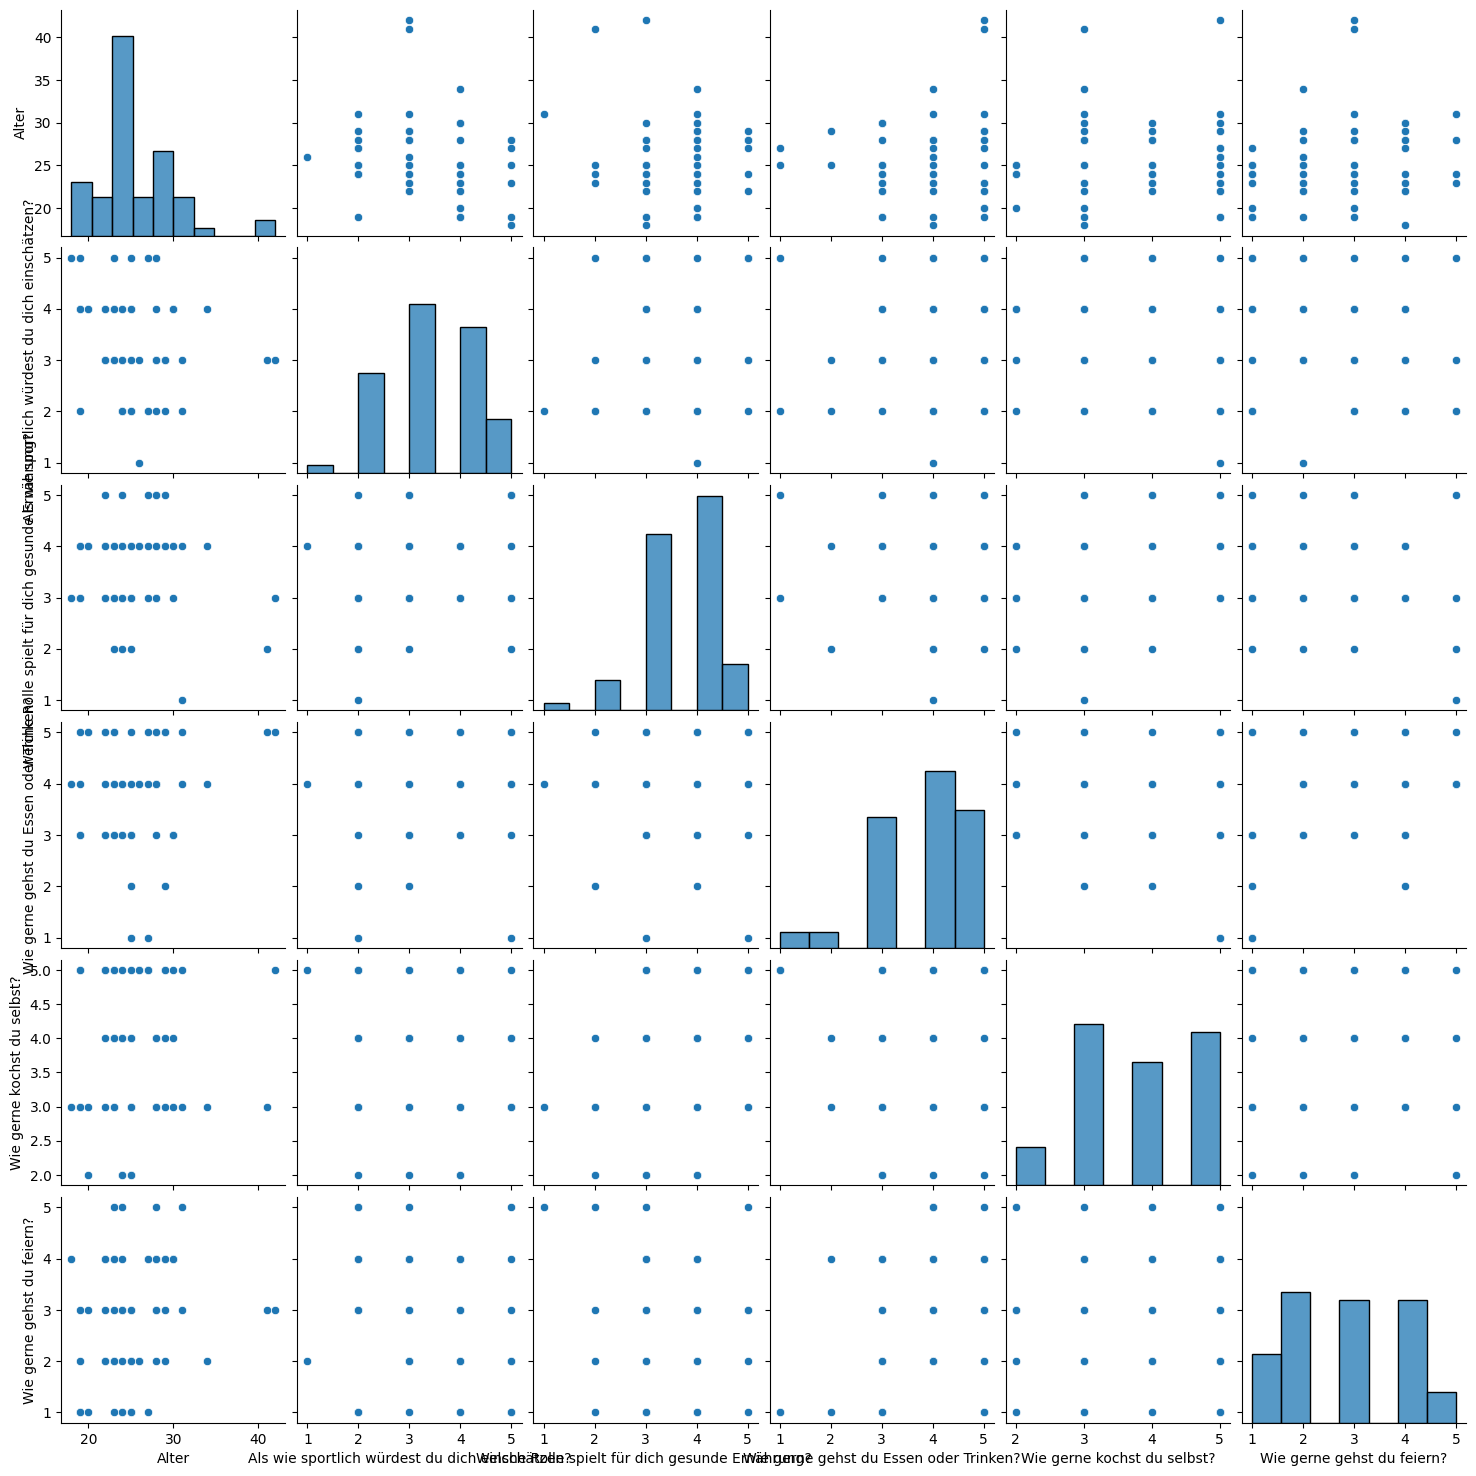

In [17]:
sb.pairplot(data.iloc[:,:10], diag_kind="hist")